#1.  Collect Academic Papers Information to Excel






##1.1 Collect Academic Papers Information and Save to json File


Install the Findpaper library

In [1]:
!pip install findpapers
!pip show findpapers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, wh

Set directory path on Google drive

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

directory_path = '/content/drive/MyDrive/RP' #@param {type:"string"}
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

Mounted at /content/drive


Set the Parameters for Findpaper
(If you want to search Scopus and IEEE, you need to enter the API key.)


In [ ]:
QUERY="'[Reinforcement learning] AND [Human] AND ([Feedback] OR [Preference])'"#@param {type:"string"}

folder_name = "search_rlhf_all"  #@param {type:"string"}
FOLDER = f'{directory_path}/{folder_name}.json'

NUM = 2000 # @param {type:"slider", min:10, max:2000, step:1}

SINCE='2013-01-01' #@param {type:"date"}
UNTIL='2023-12-31' #@param {type:"date"}

#@markdown Select Journals:

acm = True #@param {type:"boolean"}
arxiv = True #@param {type:"boolean"}
ieee = True #@param {type:"boolean"}
scopus = True #@param {type:"boolean"}

selected_databases = []
if acm:
    selected_databases.append("acm")
if arxiv:
    selected_databases.append("arxiv")
if ieee:
    selected_databases.append("ieee")
if scopus:
    selected_databases.append("scopus")

DATABASES = ",".join(selected_databases)

selected_publication_types = ["journal"]

PUBLICATION_TYPE = ",".join(selected_publication_types)

SCOPUS_TOKEN = " " #@param {type:"string"}
IEEE_TOKEN = " "#@param {type:"string"}

Execute the Findpaper command

In [ ]:
!findpapers search $FOLDER --query $QUERY --limit-db $NUM --since $SINCE --until $UNTIL --databases $DATABASES --token-scopus $SCOPUS_TOKEN --token-ieee $IEEE_TOKEN

Another interesting extra information given by Findpapers (based on Beall's List) is whether a collected paper was published by a predatory publisher (see "Publication is potentially predatory" value). That is a really good feature, because there is a lot of scientific misinformation out there.

- - -
Beall's List:
https://beallslist.net/

Potential predatory scholarly open‑access publishers

- - -

Predatory publishing:
https://en.wikipedia.org/wiki/Predatory_publishing

An exploitative academic publishing business model that involves charging publication fees to authors while only superficially checking articles for quality and legitimacy, and without providing editorial and publishing services that legitimate academic journals provide, whether open access or not. Namely, the rejection rate of predatory journals is low, but seldom is zero.

- - -
scientific misinformation:
https://www.the-scientist.com/critic-at-large/opinion-using-pokmon-to-detect-scientific-misinformation-68098

##1.2 Export to an Excel from json file


Enter the name of the json file created with Findpaper and the name of the excel file you want to output.

In [ ]:
import pandas as pd
import json
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def preprocess_title(title):
    return title.lower().replace(" ", "")

def remove_duplicate_titles(df, threshold=0.9):
    to_drop = []
    for i in range(len(df)):
        title_i = preprocess_title(df.iloc[i]['Title'])
        for j in range(i+1, len(df)):
            if j in to_drop:
                continue
            title_j = preprocess_title(df.iloc[j]['Title'])
            sim = similar(title_i, title_j)
            if sim >= threshold:
                to_drop.append(j)
    return df.drop(df.index[to_drop])

# Specify the path to your JSON file
folder_name = "search_rlhf_all"  #@param {type:"string"}
file_path = f'{directory_path}/{folder_name}.json'

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Initialize a list for the DataFrame
data_for_df = []

# Extract information from each paper
for paper in data.get("papers", []):
    # Extracting the required fields from each paper
    title = paper.get("title", "")
    year = paper.get("publication_date", "")
    abstract = paper.get("abstract", "")
    authors = "/ ".join(paper.get("authors", []))  # Joining authors list into a single string
    databases = "/ ".join(paper.get("databases", []))  # Joining databases list into a single string
    # Accessing nested 'publisher' and 'title' fields within 'publication'
    publication_info = paper.get("publication", {}) or {}
    publisher = publication_info.get("publisher", "") if publication_info else ""
    journal = publication_info.get("title", "") if publication_info else ""
    keywords = "/ ".join(paper.get("keywords", []))  # Joining keywords list into a single string
    doi = paper.get("doi", "")
    citations = paper.get("citations", "")

    # Appending the extracted information as a dictionary to the list
    data_for_df.append({
        "Title": title,
        "Year": year,
        "Abstract": abstract,
        "Authors": authors,
        "Databases": databases,
        "Publisher": publisher,
        "Journal": journal,  # Including publication title
        "Keywords": keywords,
        "DOI": doi,
        "Citations": citations
    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_for_df)
df = remove_duplicate_titles(df)

# Specify the output filename and path
output_filename = "Output"  #@param {type:"string"}
output_file = f'{directory_path}/{output_filename}.xlsx'

# Save the DataFrame as an Excel file
df.to_excel(output_file, index=False)

print("Excel file has been saved:", output_file)


#2. Clustering


##2.1 Data Treatment


In [3]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=d8bbb1bc102373be03ef88da1d8979248f813d69e6a443114ad929c18305bd75
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [4]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup
from langdetect import detect, LangDetectException
from sklearn.manifold import TSNE

The function prepares the text data by removing irrelevant elements and standardizing the format, making it suitable for further analysis like TF-IDF vectorization or clustering.

In [5]:
def clean_text(text):
    # Check if text is NaN or None and return empty string
    if pd.isnull(text):
        return ""

    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()

    # Check if text is "[No abstract available]" and return empty string if true
    if text == "[No abstract available]":
        return ""

    # Detect the language of the text and return empty string if not English
    try:
        if detect(text) != 'en':
            return ""
    except LangDetectException:
        # In case language detection fails, return empty string
        return ""

    # Define patterns to remove (leading words and optional punctuation)
    patterns_to_remove = [
        r'^Objective[:\[\]\.]*\s*',
        r'^Importance[:\[\]\.]*\s*',
        r'^Background[:\[\]\.]*\s*'
    ]

    # Remove defined patterns
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Remove specific unwanted characters
    stop_words = ['\x0c', '\n']
    for stop_word in stop_words:
        text = text.replace(stop_word, ' ')

    # Keep only alphabetic characters and replace others with a space
    clean_text = re.sub('[^a-zA-Z]+', ' ', text)

    # Convert to lowercase
    return clean_text.lower()

Select the name of the Excel output from the json file and convert the abstract text into data suitable for clustering processing.

In [6]:
output_filename = "Output"  #@param {type:"string"}
output_file = f'{directory_path}/{output_filename}.xlsx'
df = pd.read_excel(output_file, usecols=['Title', 'Year', 'Abstract', 'Authors', 'Databases', 'Publisher', 'Journal', 'Keywords', 'DOI', 'Citations'])

df['clean_abstract'] = df['Abstract'].apply(clean_text)

# Find the index of the 'Abstract' column and insert 'clean_abstract' right after it
abstract_col_index = df.columns.get_loc('Abstract') + 1
df.insert(abstract_col_index, 'Clean Abstract', df.pop('clean_abstract'))

df['ID'] = range(len(df))

# Filter out rows where 'clean_abstract' is empty
filtered_df = df[df['Clean Abstract'].str.strip().astype(bool)].copy()

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=10000,
    stop_words='english',
    use_idf=True
)

# Fit the TfidfVectorizer to the non-empty 'Clean Abstracts' and transform
if not filtered_df.empty:
    tfidf.fit(filtered_df['Clean Abstract'])  # Learn vocabulary and IDF from the non-empty cleaned abstracts
    text = tfidf.transform(filtered_df['Clean Abstract'])  # Convert non-empty cleaned abstracts to TF-IDF feature matrix
else:
    text = None  # In case there are no non-empty cleaned abstracts

df.head(30)  # Display the first few rows for verification

,Title,Year,Abstract,Clean Abstract,Authors,Databases,Publisher,Journal,Keywords,DOI,Citations,ID
0,Uncertainty-Penalized Reinforcement Learning f...,2023-12-30,Reinforcement learning from human feedback (RL...,reinforcement learning from human feedback rlh...,"Zhai, Yuanzhao/ Zhang, Han/ Lei, Yu/ Yu, Yue/ ...",arXiv,NaN,NaN,NaN,NaN,NaN,0
1,Efficient Two-Phase Offline Deep Reinforcement...,2023-12-30,"In this work, we consider the offline preferen...",in this work we consider the offline preferenc...,"Xu, Yinglun/ Singh, Gagandeep",arXiv,NaN,NaN,NaN,NaN,NaN,1
2,Knowledge-guided robot learning on compliance ...,2023-12-30,Nowadays industrial robots have become the key...,nowadays industrial robots have become the key...,Quan Liu/ Zhenrui Ji/ Wenjun Xu/ Zhihao Liu/ B...,Scopus/ ACM,Elsevier Ltd.,Expert Systems with Applications,Model-based reinforcement learning/ Compliance...,10.1016/j.eswa.2023.121037,2.0,2
3,"Preference as Reward, Maximum Preference Optim...",2023-12-27,Preference learning is a key technology for al...,preference learning is a key technology for al...,"Jiang, Zaifan/ Huang, Xing/ Wei, Chao",arXiv,NaN,NaN,NaN,NaN,NaN,3
4,Aligning Large Language Models with Human Pref...,2023-12-26,Aligning large language models (LLMs) with hum...,aligning large language models llms with human...,"Liu, Wenhao/ Wang, Xiaohua/ Wu, Muling/ Li, Ti...",arXiv,NaN,NaN,NaN,NaN,NaN,4
5,Spatial-Temporal Interplay in Human Mobility: ...,2023-12-25,"In the realm of human mobility, the decision-m...",in the realm of human mobility the decision ma...,"Zhang, Zhaofan/ Xiao, Yanan/ Jiang, Lu/ Yang, ...",arXiv,NaN,NaN,NaN,NaN,NaN,5
6,YAYI 2: Multilingual Open-Source Large Languag...,2023-12-22,As the latest advancements in natural language...,as the latest advancements in natural language...,"Luo, Yin/ Kong, Qingchao/ Xu, Nan/ Cao, Jia/ H...",arXiv,NaN,NaN,NaN,NaN,NaN,6
7,A Survey of Reinforcement Learning from Human ...,2023-12-22,Reinforcement learning from human feedback (RL...,reinforcement learning from human feedback rlh...,"Kaufmann, Timo/ Weng, Paul/ Bengs, Viktor/ Hül...",arXiv,NaN,NaN,NaN,NaN,NaN,7
8,REBEL: A Regularization-Based Solution for Rew...,2023-12-22,"In this work, we propose REBEL, an algorithm f...",in this work we propose rebel an algorithm for...,"Chakraborty, Souradip/ Bhaskar, Amisha/ Singh,...",arXiv,NaN,NaN,NaN,NaN,NaN,8
9,Benchmarking Multi-Agent Preference-based Rein...,2023-12-21,Preference-based Reinforcement Learning (PbRL)...,preference based reinforcement learning pbrl i...,"Bhambri, Siddhant/ Verma, Mudit/ Murthy, Anil/...",arXiv,NaN,NaN,NaN,NaN,NaN,9


Check the data information of the created TF-IDF

In [7]:
text

<1262x3440 sparse matrix of type '<class 'numpy.float64'>'
	with 95321 stored elements in Compressed Sparse Row format>

##2.2 K-means

### 2.2.1 Elbow Method




Estimating the optimal number of clusters using the Sum of Squared Errors (SSE) involves analyzing the clustering performance as the number of clusters changes.


**SSE (Sum of Squared Errors):**
SSE is a common metric used to evaluate the performance of clustering algorithms. It is calculated as the sum of the squared distances between each data point and the centroid of the cluster it belongs to.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters
Fit 52 clusters
Fit 54 clusters
Fit 56 clusters
Fit 58 clusters
Fit 60 clusters


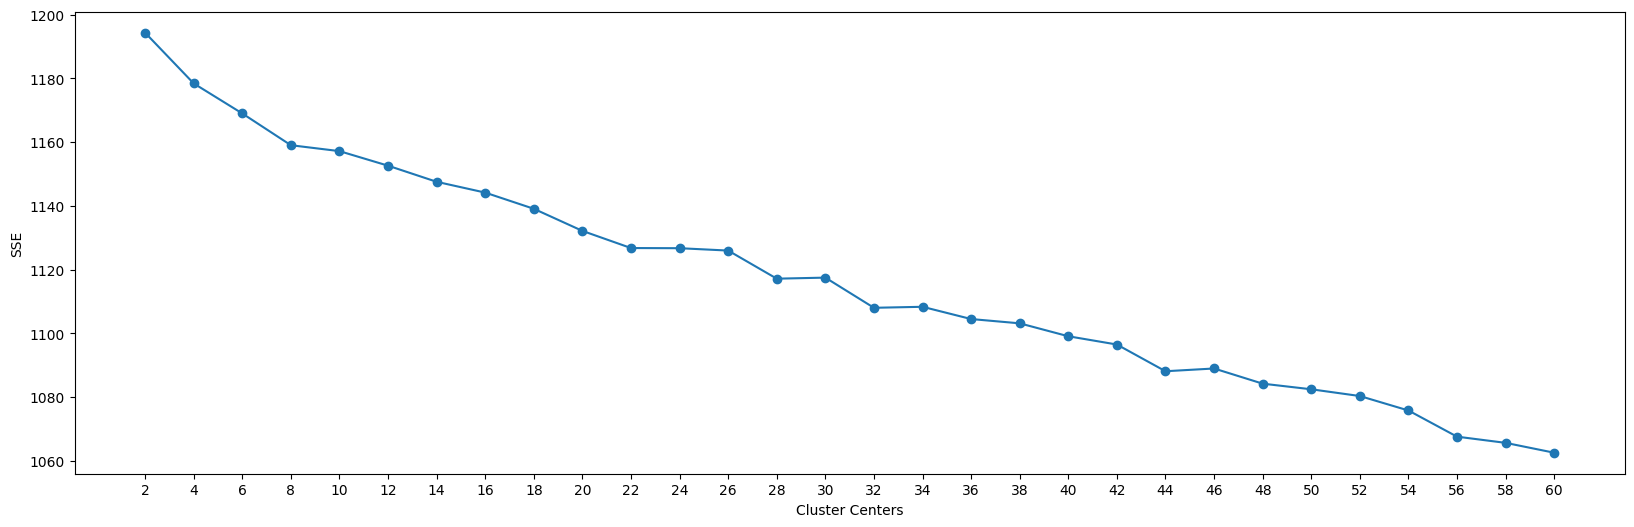

In [8]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)

    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(text).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1, figsize=(20, 6))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')

cluster_num = 60 # @param {type:"slider", min:1, max:100, step:1}
find_optimal_clusters(text, cluster_num)

### 2.2.2. t-SNE Cluster Plot


Add a new excel file with cluster information added

In [9]:
# Clustering
n_clusters = 10 # @param {type:"slider", min:1, max:100, step:1}
clusters = MiniBatchKMeans(n_clusters=n_clusters, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

# Add cluster labels to filtered_df using ID
filtered_df['Cluster'] = clusters

# Merge filtered_df with df using ID to retain cluster labels
df = pd.merge(df, filtered_df[['ID', 'Cluster']], on='ID', how='left')
df['Cluster'].fillna('No Cluster', inplace=True)

# Save updated DataFrame to Excel
cluster_filename = "Cluster"  #@param {type:"string"}
cluster_file = f'{directory_path}/{cluster_filename}.xlsx'
output_excel_path = cluster_file

# Save updated DataFrame to Excel, excluding the 'ID' column for final output
df.drop(columns=['ID']).to_excel(output_excel_path, index=False)

Display cluster distribution with t-SNE Cluster Plot

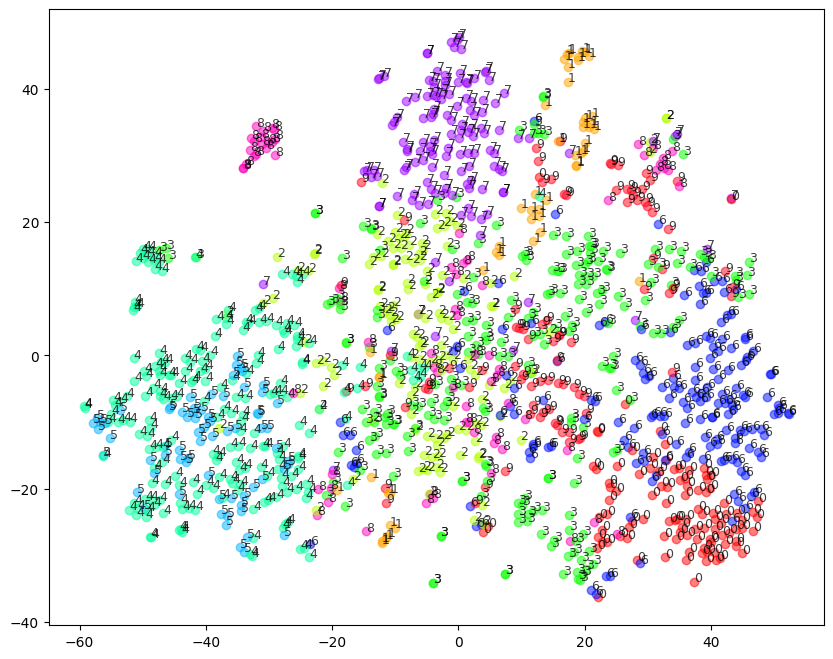

In [10]:
def plot_tsne(data, labels):
    max_label = max(labels)
    sample_size = min(3000, data.shape[0])
    max_items = np.random.choice(range(data.shape[0]), size=sample_size, replace=False)

    # Determine the number of components for PCA before TSNE
    n_components_pca = min(50, data.shape[1])  # Use 50 or the feature size, whichever is smaller

    # Reduce dimensionality before TSNE
    pca_result = PCA(n_components=n_components_pca).fit_transform(data[max_items,:].toarray())

    # Perform TSNE
    tsne = TSNE(perplexity=min(30, sample_size - 1), n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_result = tsne.fit_transform(pca_result)

    # Plot TSNE
    plt.figure(figsize=(10, 8))

    # Coloring and labeling each point based on its cluster label
    for i, _ in enumerate(tsne_result):
        plt.scatter(tsne_result[i, 0], tsne_result[i, 1], c=[cm.hsv(labels[max_items][i]/max_label)], alpha=0.5)
        plt.text(tsne_result[i, 0], tsne_result[i, 1], str(labels[max_items][i]), fontsize=9, alpha=0.75)

    plt.show()

# Assuming `text` is your feature matrix and `clusters` are the cluster labels obtained from MiniBatchKMeans
plot_tsne(text, clusters)


Check the top 10 with the highest TF-IDF values for each cluster

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 10)


Cluster 0
human,llm,model,large,chatgpt,tuning,fine,models,language,llms

Cluster 1
explanations,coach,action,agents,trainer,tamer,feedback,human,advice,agent

Cluster 2
energy,feedback,proposed,model,deep,human,based,neural,network,control

Cluster 3
preferences,game,environment,ai,feedback,reward,agents,human,agent,rl

Cluster 4
cognitive,reward,positive,patients,participants,negative,task,related,social,feedback

Cluster 5
rpe,striatal,value,errors,signals,striatum,dopamine,error,prediction,reward

Cluster 6
rl,feedback,language,preferences,preference,human,models,reward,model,rlhf

Cluster 7
real,robotic,navigation,feedback,approach,task,control,robots,human,robot

Cluster 8
autonomous,deep,based,demonstrations,data,avs,decision,driver,human,driving

Cluster 9
users,approach,image,search,method,human,interactive,reward,irl,user


Display the number of papers classified into each cluster as a bar graph

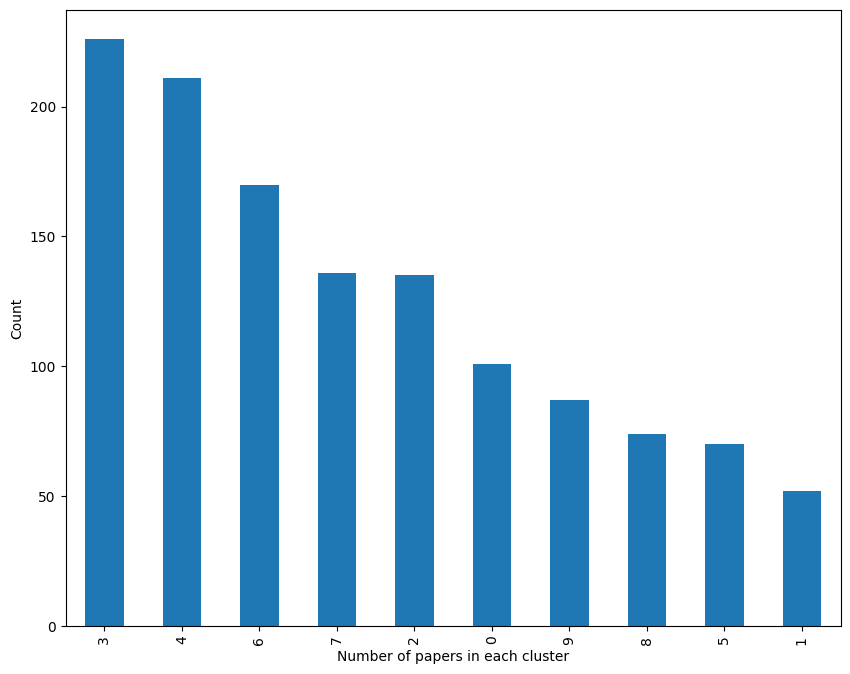

,Frequency
3,226
4,211
6,170
7,136
2,135
0,101
9,87
8,74
5,70
1,52


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

df = pd.read_excel(cluster_file, usecols=['Cluster'])
cluster_list = pd.to_numeric(df['Cluster'], errors='coerce').dropna().astype(int).tolist()

cluster_counts = pd.Series(cluster_list).value_counts()


plt.figure(figsize=(10, 8))
cluster_counts.plot(kind='bar')
plt.xlabel('Number of papers in each cluster')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

top30_clusters_df = cluster_counts.head(30).to_frame('Frequency')
display(HTML(top30_clusters_df.to_html()))

Check cluster accuracy using each score and index

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

predicted_clusters = df['Cluster']
used_indices = filtered_df.index.tolist()
used_clusters = predicted_clusters.loc[used_indices]
used_clusters = pd.to_numeric(used_clusters, errors='coerce').dropna()
used_clusters = used_clusters.reset_index(drop=True)
tfidf_dense = text.toarray()  # Convert the transformed TF-IDF data to a dense format
tfidf_dense_filtered = tfidf_dense[used_clusters.index]

silhouette_avg = silhouette_score(tfidf_dense_filtered, used_clusters)
print("Silhouette Score: ", silhouette_avg)

calinski_harabasz = calinski_harabasz_score(tfidf_dense_filtered, used_clusters)
print("Calinski-Harabasz Index: ", calinski_harabasz)

davies_bouldin = davies_bouldin_score(tfidf_dense_filtered, used_clusters)
print("Davies-Bouldin Index: ", davies_bouldin)


Silhouette Score:  0.007741263992295704
Calinski-Harabasz Index:  6.143597063475674
Davies-Bouldin Index:  8.216099815734712


# 3. Evaluation

##3.1 Compared between Control papers and Result

In [12]:
!pip install openpyxl

Prepare a list of the paper information (title, publication date, abstract) that you need as a control paper. That list is compared with the center of the Excel list created earlier, and 1 is added to the row of the matching paper.

In [13]:
import openpyxl
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Set the file name
output_filename = "Cluster" #@param {type:"string"}
output_file = f'{directory_path}/{output_filename}.xlsx'
control_filename = "ControlPaper" #@param {type:"string"}
control_file = f'{directory_path}/{control_filename}.xlsx'
check_filename = "Check" #@param {type:"string"}
check_file = f'{directory_path}/{check_filename}.xlsx'

wb1 = openpyxl.load_workbook(control_file)
wb2 = openpyxl.load_workbook(output_file)

ws1 = wb1.active
ws2 = wb2.active

# Function to find the first empty column in a given row
def find_first_empty_column(row):
    col = 1
    while ws2.cell(row=row, column=col).value is not None:
        col += 1
    return col

# Add a new column with a dynamic header based on processing, similar to 'clean_abstract'
def add_new_column_with_header(header_name):
    header_col = find_first_empty_column(1)
    ws2.cell(row=1, column=header_col).value = header_name

    # Looping through rows to compare values or perform any other processing
    for row1 in range(2, ws1.max_row + 1):
        value1 = ws1.cell(row=row1, column=1).value
        if value1 is not None:  # Ensure value is not None
            value1 = str(value1).strip().lower() # Strip spaces and convert to lowercase
        for row2 in range(2, ws2.max_row + 1):
            value2 = ws2.cell(row=row2, column=1).value
            if value2 is not None:  # Ensure value is not None
                value2 = str(value2).strip().lower()  # Strip spaces and convert to lowercase
            # Consider as a match if similarity is 90% or more
            if value1 and value2 and similar(value1, value2) >= 0.90:
                ws2.cell(row=row2, column=header_col).value = "1"  # Mark "1" in the new column for matched rows

# Call the function with the desired header name
add_new_column_with_header("Control Paper")

# Save the changes
wb2.save(check_file)

See how comprehensive the list of Control papers is

In [ ]:
# Load the updated workbook
wb2 = openpyxl.load_workbook(check_file)

# Select the active worksheet
ws2 = wb2.active

# Initialize the count for '1's in the "Control Paper" column
control_paper_count = 0

# Find the "Control Paper" column index
control_paper_col_index = None
for col in ws2.iter_cols(min_row=1, max_row=1, values_only=False):
    if col[0].value == "Control Paper":
        control_paper_col_index = col[0].column
        break

# Ensure that the "Control Paper" column was found before proceeding
if control_paper_col_index is not None:
    # Loop through rows starting from the second row to count '1's in the "Control Paper" column
    for row in ws2.iter_rows(min_row=2, min_col=control_paper_col_index, max_col=control_paper_col_index, values_only=True):
        if row[0] == "1":
            control_paper_count += 1

# Load the control workbook to count its rows
wb1 = openpyxl.load_workbook(control_file)
ws1 = wb1.active
control_paper_rows = ws1.max_row - 1  # Subtract 1 to exclude the header row

# Calculate the percentage
percentage = (control_paper_count / control_paper_rows) * 100 if control_paper_rows > 0 else 0

print(f"Count of Control Paper in the results : {control_paper_count}")
print(f"Number of Control Paper: {control_paper_rows}")
print(f"Percentage : {percentage:.2f}%")


Count of Control Paper in the results : 23
Number of Control Paper: 43
Percentage : 53.49%


Bar chart showing the number of control papers in each cluster

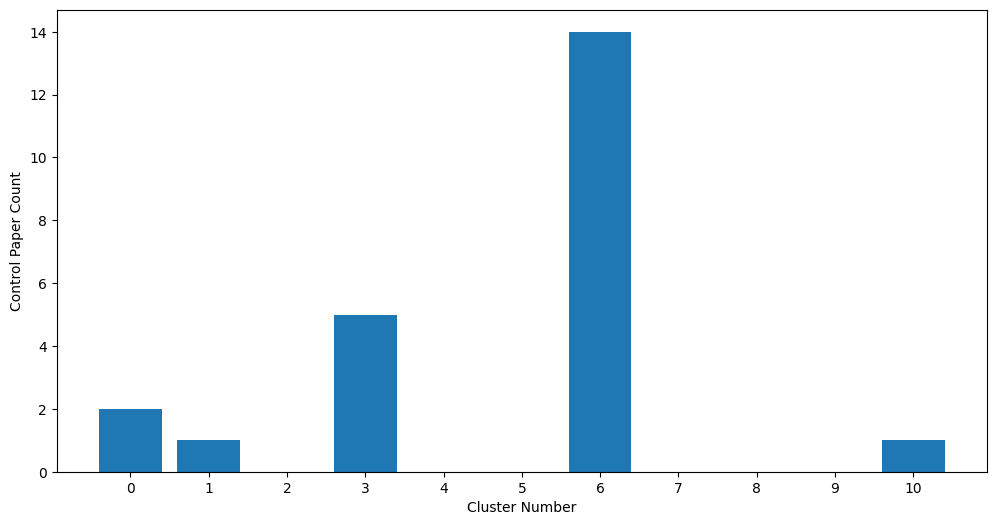

,Cluster,Control Paper Count
0,0,2
1,1,1
2,2,0
3,3,5
4,4,0
5,5,0
6,6,14
7,7,0
8,8,0
9,9,0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel(check_file, usecols=['Cluster', 'Control Paper'])

df['Cluster'] = pd.to_numeric(df['Cluster'], errors='coerce')

df = df.dropna(subset=['Cluster'])

# Assuming 'check_file' is the path to the Excel file containing the data
df = pd.read_excel(check_file, usecols=['Cluster', 'Control Paper'])

# Group the data by 'Cluster' and count the number of '1's in 'Control Paper' for each cluster
cluster_control_paper_counts = df.groupby('Cluster')['Control Paper'].count().reset_index()

# Rename the columns for clarity
cluster_control_paper_counts.columns = ['Cluster', 'Control Paper Count']

cluster_mapping = {name: idx for idx, name in enumerate(cluster_control_paper_counts['Cluster'].unique())}
cluster_control_paper_counts['Cluster'] = cluster_control_paper_counts['Cluster'].map(cluster_mapping)

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(cluster_control_paper_counts['Cluster'], cluster_control_paper_counts['Control Paper Count'])
plt.xlabel('Cluster Number')
plt.ylabel('Control Paper Count')
plt.xticks(range(int(cluster_control_paper_counts['Cluster'].min()), int(cluster_control_paper_counts['Cluster'].max()) + 1))

plt.show()

cluster_control_paper_counts

## 3.2. Keyword

Compare the top keywords created with TF-IDF and the keywords input by each author using a pie chart

### 3.2.1 TF-IDF Keywords from Abstract

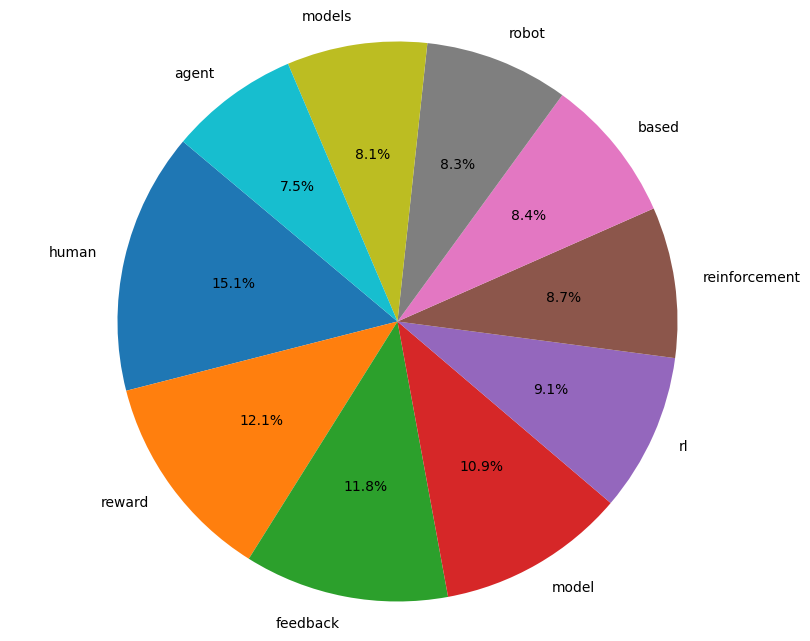

,Keyword,TF-IDF
1525,human,60.593659
2746,reward,48.635275
1292,feedback,47.385999
2017,model,43.693026
2760,rl,36.690760
2642,reinforcement,34.956294
323,based,33.607709
2766,robot,33.375530
2022,models,32.521384
120,agent,30.085988


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Summing up the TF-IDF scores for each feature
sums = np.array(text.sum(axis=0)).flatten()

# Getting feature names (words/terms)
features = tfidf.get_feature_names_out()

# Mapping feature names with their corresponding sums
data = list(zip(features, sums))

# Creating a DataFrame from the mapped data
df_tfidf = pd.DataFrame(data, columns=['Keyword', 'TF-IDF'])

# Sorting the DataFrame by TF-IDF in descending order to get top 10 terms
df_top10 = df_tfidf.sort_values(by='TF-IDF', ascending=False).head(10)
df_top50 = df_tfidf.sort_values(by='TF-IDF', ascending=False).head(50)

# Plotting the top 10 terms as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(df_top10['TF-IDF'], labels=df_top10['Keyword'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the pie chart
plt.show()
df_top50.head(50)

### 3.2.2 Keywords from manually input by each author

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

check_filename = "Check" #@param {type:"string"}
check_file = f'{directory_path}/{check_filename}.xlsx'

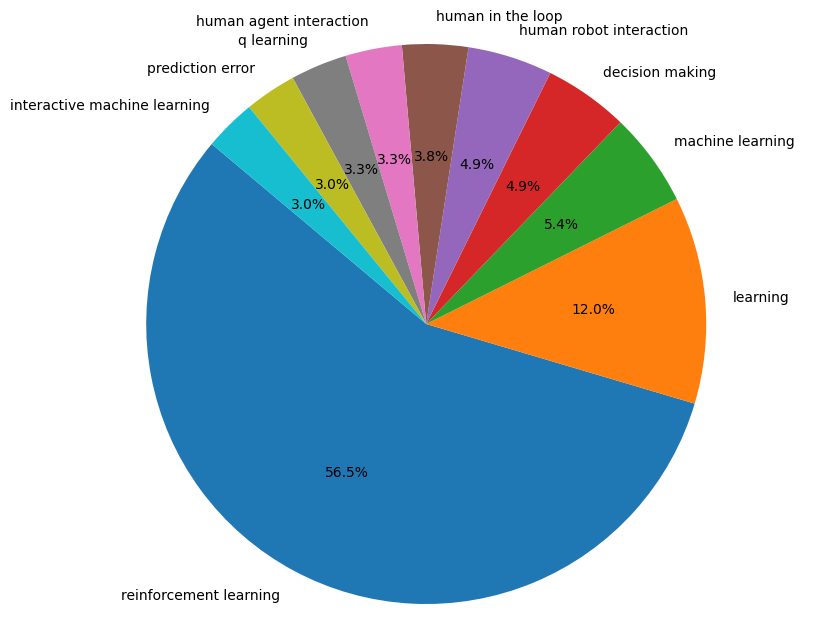

,Keyword,Count
8,reinforcement learning,208
91,learning,44
141,machine learning,20
106,decision making,18
138,human robot interaction,18
5,human in the loop,14
368,human agent interaction,12
70,q learning,12
11,prediction error,11
72,interactive machine learning,11


In [23]:
df = pd.read_excel(check_file, usecols=['Keywords'])

keywords_count = {}

for keywords in df['Keywords'].dropna():
    for keyword in keywords.split('/'):
        keyword = keyword.strip()
        cleaned_keyword = clean_text(keyword)
        if cleaned_keyword:
            if cleaned_keyword in keywords_count:
                keywords_count[cleaned_keyword] += 1
            else:
                keywords_count[cleaned_keyword] = 1

keywords_df = pd.DataFrame(list(keywords_count.items()), columns=['Keyword', 'Count'])

top10_keywords_df = keywords_df.sort_values(by='Count', ascending=False).head(10)
top30_keywords_df = keywords_df.sort_values(by='Count', ascending=False).head(30)

plt.figure(figsize=(10, 8))
plt.pie(top10_keywords_df['Count'], labels=top10_keywords_df['Keyword'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')

plt.show()
top30_keywords_df.head(30)


## 3.3 Publication Count by Year

Display the number of papers published each year in a bar graph and table

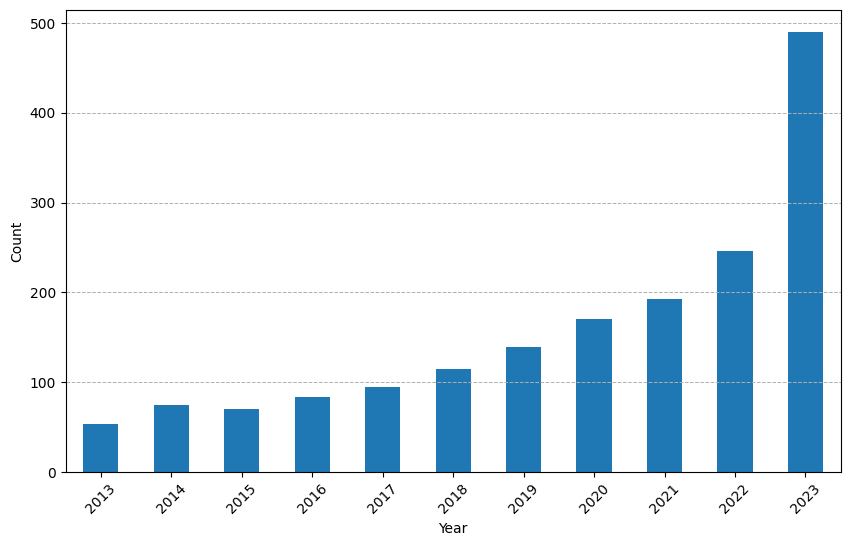

,Count
2013,53
2014,75
2015,70
2016,83
2017,94
2018,115
2019,139
2020,170
2021,192
2022,246


In [18]:
df = pd.read_excel(check_file, usecols=['Year'])

df['Year'] = pd.to_datetime(df['Year'], format='%Y-%m-%d').dt.year

year_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

pd.set_option('display.max_colwidth', 50)
year_df = year_counts.head(11).to_frame('Count')

display(HTML(year_df.to_html(escape=False)))

## 3.4 Databese and Journal

Count databases and journals from each paper and display them in bar graph and table

### 3.4.1 Database

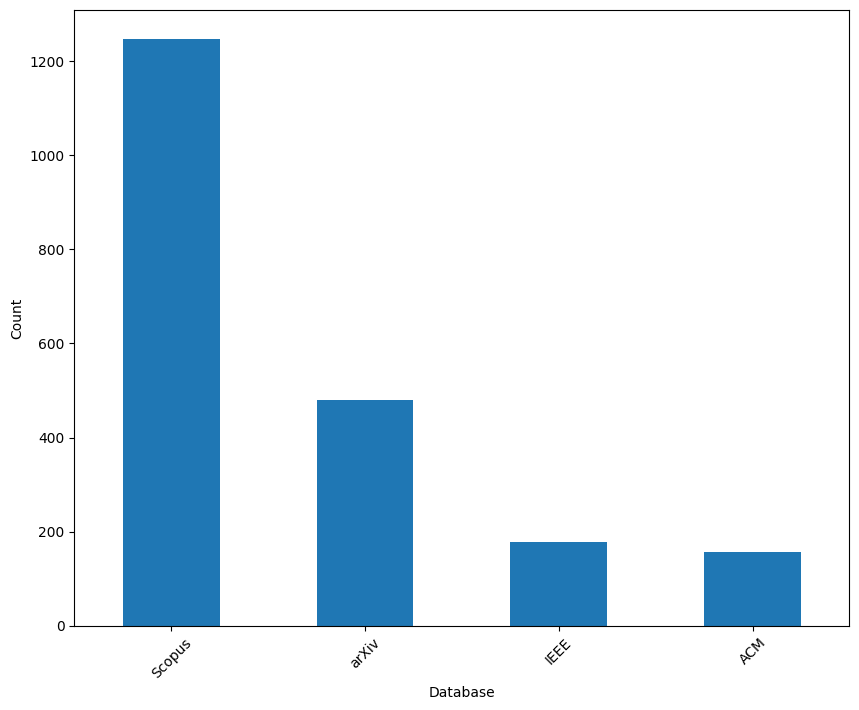

,Count
Scopus,1247
arXiv,480
IEEE,179
ACM,157


In [19]:
df = pd.read_excel(check_file, usecols=['Databases'])
database_list = df['Databases'].dropna().apply(lambda x: x.split('/')).tolist()

flat_database_list = [item.strip() for sublist in database_list for item in sublist]

database_counts = pd.Series(flat_database_list).value_counts()

plt.figure(figsize=(10, 8))
database_counts.plot(kind='bar')
plt.xlabel('Database')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

database_counts.head()

pd.set_option('display.max_colwidth', 50)
database_df = database_counts.head().to_frame('Count')

display(HTML(database_df.to_html(escape=False)))

### 3.4.2 Jounal

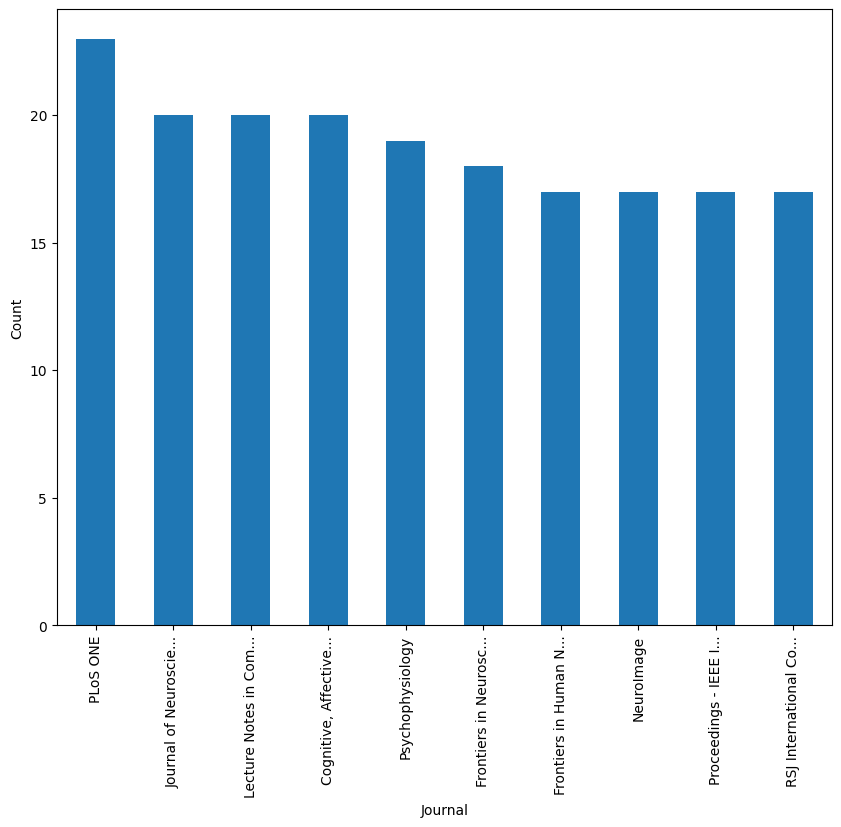

,Count
PLoS ONE,23
Journal of Neuroscience,20
Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics),20
"Cognitive, Affective and Behavioral Neuroscience",20
Psychophysiology,19
Frontiers in Neuroscience,18
Frontiers in Human Neuroscience,17
NeuroImage,17
Proceedings - IEEE International Conference on Robotics and Automation,17
RSJ International Conference on Intelligent Robots and Systems (IROS),17


In [20]:
df = pd.read_excel(check_file, usecols=['Journal'])
journal_list = df['Journal'].dropna().apply(lambda x: x.split('/')).tolist()

flat_journal_list = [item.strip() for sublist in journal_list for item in sublist]

journal_counts = pd.Series(flat_journal_list).value_counts()
top10_journals = journal_counts.head(10)

def abbreviate_journal_name(name, max_length=20):
    if len(name) > max_length:
        return name[:max_length] + "..."
    else:
        return name

abbreviated_journals = top10_journals.index.map(lambda x: abbreviate_journal_name(x))

plt.figure(figsize=(10, 8))
top10_journals.plot(kind='bar')
plt.xlabel('Journal')
plt.ylabel('Count')
plt.xticks(range(len(abbreviated_journals)), abbreviated_journals, rotation=90)
plt.show()

pd.set_option('display.max_colwidth', 50)
top30_journals_df = journal_counts.head(30).to_frame('Count')

display(HTML(top30_journals_df.to_html(escape=False)))

## 3.5. First Authors

Count only the first author from each paper and display it in bar graph and table

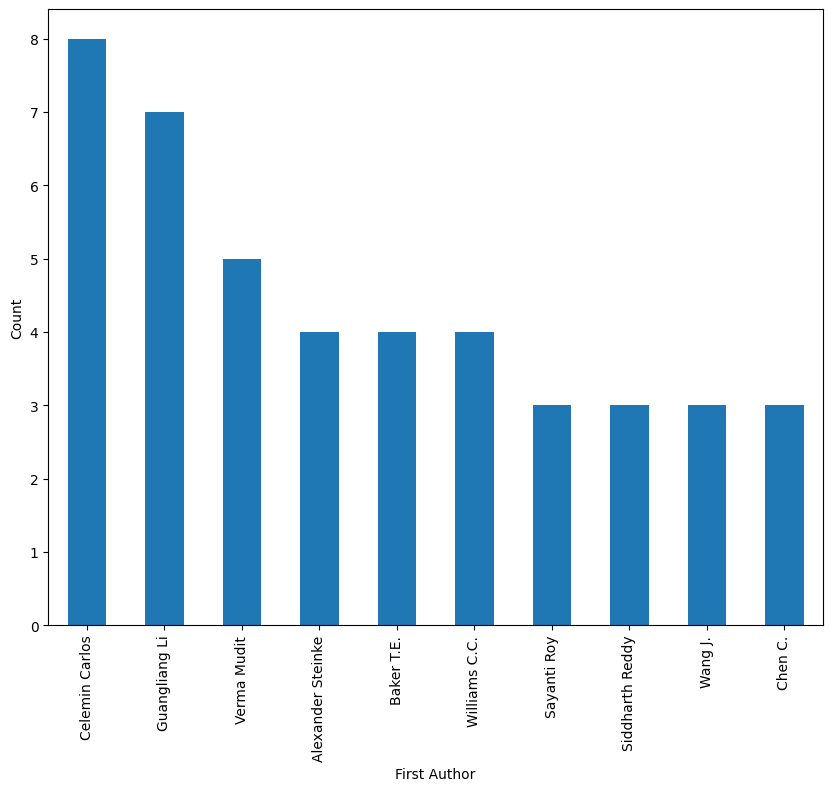

,Count
Celemin Carlos,8
Guangliang Li,7
Verma Mudit,5
Alexander Steinke,4
Baker T.E.,4
Williams C.C.,4
Sayanti Roy,3
Siddharth Reddy,3
Wang J.,3
Chen C.,3


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def normalize_author_name(name):
    parts = name.replace(',', '').split()
    parts = [p for p in parts if len(p) > 1]
    parts.sort(key=len, reverse=True)
    return " ".join(parts)

df = pd.read_excel(check_file, usecols=['Authors'])

first_authors_normalized = df['Authors'].dropna().apply(lambda x: normalize_author_name(x.split('/')[0].strip())).tolist()

first_author_counts_normalized = pd.Series(first_authors_normalized).value_counts()

top10_first_authors_normalized = first_author_counts_normalized.head(10)
plt.figure(figsize=(10, 8))
top10_first_authors_normalized.plot(kind='bar')
plt.xlabel('First Author')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

top30_first_authors_normalized_df = first_author_counts_normalized.head(30).to_frame('Count')
display(top30_first_authors_normalized_df)


## 3.6 Citations

Table of citation counts for each paper

In [22]:
df = pd.read_excel(check_file, usecols=['Title', 'Citations'])

sorted_df = df.dropna(subset=['Citations']).astype({'Citations': 'int'}).sort_values('Citations', ascending=False)

top30_papers = sorted_df.head(30)

display(HTML(top30_papers.to_html(index=False)))

Title,Citations
Deep Learning in neural networks: An overview,12320
Interactive machine learning for health informatics: when do we need the human-in-the-loop?,581
Training language models to follow instructions with human feedback,557
Reinforcement learning for demand response: A review of algorithms and modeling techniques,427
Neurophysiology of performance monitoring and adaptive behavior,419
Deep visual foresight for planning robot motion,414
Reinforcement Learning and Approximate Dynamic Programming for Feedback Control,344
"Adaptive Resonance Theory: How a brain learns to consciously attend, learn, and recognize a changing world",330
Towards Diverse and Natural Image Descriptions via a Conditional GAN,309
Prediction error in reinforcement learning: A meta-analysis of neuroimaging studies,296
